
Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Assignment/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Assignment


In [0]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
import transforme

trainloader = transforme.trainloader
trainloader1 = transforme.trainloader1
testloader =  transforme.testloader
testloader1 = transforme.testloader1
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



plane   dog  deer  deer


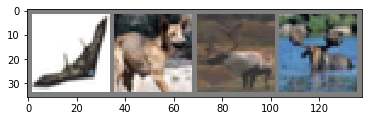

In [4]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader1)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [5]:
import modele
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = modele.Net().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
          Dropout-12           [-1, 32, 32, 32]               0
        MaxPool2d-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1

In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [7]:
import torch
from tqdm import tqdm
import traine
import teste
test_acc = []
train_acc = []
for epoch in range(50):  # loop over the dataset multiple times
    scheduler.step()
    train_acc.append(traine.train(net, device, trainloader, optimizer, criterion, epoch))
    test_acc.append(teste.test(net, device, testloader))
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch= 0 Loss=0.900501549243927 Batch_id=390 Accuracy=70.00: 100%|██████████| 391/391 [00:15<00:00, 25.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 38 %


Epoch= 1 Loss=1.0588587522506714 Batch_id=390 Accuracy=66.25: 100%|██████████| 391/391 [00:15<00:00, 24.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 59 %


Epoch= 2 Loss=0.8071373105049133 Batch_id=390 Accuracy=72.50: 100%|██████████| 391/391 [00:15<00:00, 29.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 66 %


Epoch= 3 Loss=0.7753040194511414 Batch_id=390 Accuracy=76.25: 100%|██████████| 391/391 [00:15<00:00, 24.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 70 %


Epoch= 4 Loss=0.7611747980117798 Batch_id=390 Accuracy=77.50: 100%|██████████| 391/391 [00:15<00:00, 24.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 70 %


Epoch= 5 Loss=0.711210310459137 Batch_id=390 Accuracy=77.50: 100%|██████████| 391/391 [00:15<00:00, 25.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 70 %


Epoch= 6 Loss=0.5995146632194519 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:15<00:00, 25.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 75 %


Epoch= 7 Loss=0.6818562150001526 Batch_id=390 Accuracy=81.25: 100%|██████████| 391/391 [00:15<00:00, 25.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 73 %


Epoch= 8 Loss=0.38283950090408325 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:16<00:00, 24.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 78 %


Epoch= 9 Loss=0.7362688779830933 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:15<00:00, 25.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 76 %


Epoch= 10 Loss=0.6065927743911743 Batch_id=390 Accuracy=82.50: 100%|██████████| 391/391 [00:15<00:00, 25.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 73 %


Epoch= 11 Loss=0.5477072596549988 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:15<00:00, 25.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 79 %


Epoch= 12 Loss=0.5951845049858093 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 25.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 75 %


Epoch= 13 Loss=0.43597063422203064 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 25.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 77 %


Epoch= 14 Loss=0.2837520241737366 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:15<00:00, 24.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 15 Loss=0.32999494671821594 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:15<00:00, 24.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 16 Loss=0.45591944456100464 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:15<00:00, 24.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 17 Loss=0.34427064657211304 Batch_id=390 Accuracy=86.25: 100%|██████████| 391/391 [00:15<00:00, 28.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 82 %


Epoch= 18 Loss=0.5728428959846497 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:15<00:00, 29.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 19 Loss=0.32335829734802246 Batch_id=390 Accuracy=86.25: 100%|██████████| 391/391 [00:15<00:00, 29.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 20 Loss=0.28409165143966675 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:15<00:00, 25.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 21 Loss=0.3026675879955292 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:15<00:00, 25.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 22 Loss=0.4658944606781006 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 25.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 23 Loss=0.5078387260437012 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 28.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 24 Loss=0.3004923462867737 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 29.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 82 %


Epoch= 25 Loss=0.4464798867702484 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:15<00:00, 25.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 80 %


Epoch= 26 Loss=0.37460747361183167 Batch_id=390 Accuracy=92.50: 100%|██████████| 391/391 [00:15<00:00, 25.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 79 %


Epoch= 27 Loss=0.40885215997695923 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 29.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 28 Loss=0.19289472699165344 Batch_id=390 Accuracy=92.50: 100%|██████████| 391/391 [00:15<00:00, 29.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 29 Loss=0.2558969259262085 Batch_id=390 Accuracy=92.50: 100%|██████████| 391/391 [00:15<00:00, 25.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 30 Loss=0.27636152505874634 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 25.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 31 Loss=0.285329669713974 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:15<00:00, 25.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 32 Loss=0.36020898818969727 Batch_id=390 Accuracy=96.25: 100%|██████████| 391/391 [00:15<00:00, 24.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 82 %


Epoch= 33 Loss=0.2830203175544739 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 25.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 34 Loss=0.3285621106624603 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 25.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 35 Loss=0.20054340362548828 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 29.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85 %


Epoch= 36 Loss=0.2198166400194168 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:15<00:00, 25.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85 %


Epoch= 37 Loss=0.3339776396751404 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:15<00:00, 28.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 38 Loss=0.3410032391548157 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 25.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 39 Loss=0.32008737325668335 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 25.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 40 Loss=0.365554541349411 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 29.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 82 %


Epoch= 41 Loss=0.2538034915924072 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:15<00:00, 25.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 42 Loss=0.22026102244853973 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:15<00:00, 24.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 43 Loss=0.21527910232543945 Batch_id=390 Accuracy=92.50: 100%|██████████| 391/391 [00:15<00:00, 25.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 44 Loss=0.3246665596961975 Batch_id=390 Accuracy=92.50: 100%|██████████| 391/391 [00:15<00:00, 29.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 45 Loss=0.3505575954914093 Batch_id=390 Accuracy=92.50: 100%|██████████| 391/391 [00:15<00:00, 28.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 46 Loss=0.17702363431453705 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 25.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 47 Loss=0.21466317772865295 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:15<00:00, 25.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 48 Loss=0.3590925335884094 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:15<00:00, 25.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 49 Loss=0.2582722306251526 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 24.46it/s]
100%|██████████| 79/79 [00:02<00:00, 35.38it/s]


Accuracy of the network on the 10000 test images: 85 %
Finished Training


Text(0, 0.5, 'Accuracy')

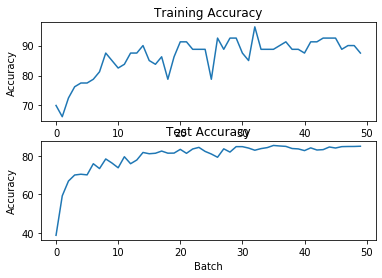

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
axs[0].plot(train_acc)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Accuracy")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Accuracy")

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:   bird   cat   cat  ship


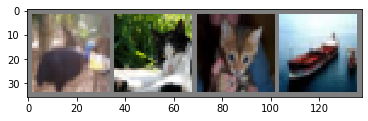

In [9]:
dataiter = iter(testloader1)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images.cuda())

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   deer   cat   cat  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [12]:
teste.test_categorywise(net, device, testloader, classes)

100%|██████████| 79/79 [00:02<00:00, 32.76it/s]

Accuracy of plane : 97 %
Accuracy of   car : 84 %
Accuracy of  bird : 78 %
Accuracy of   cat : 69 %
Accuracy of  deer : 87 %
Accuracy of   dog : 73 %
Accuracy of  frog : 97 %
Accuracy of horse : 84 %
Accuracy of  ship : 92 %
Accuracy of truck : 77 %
